In [1]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import random
import glob
import CNN_Module as cnn_module
import models
import glue_code

Using TensorFlow backend.


In [2]:
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/control/'))
sus_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
print(len(control_cells))
print(len(sus_cells))

360
318


In [3]:
import warnings
warnings.filterwarnings('ignore')
model = models.get_luke_model(80)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
result_acc = []
result_val_acc = []
for repeat in np.arange(0,2):
print('repeat =', repeat)
    #prep cells for feeding into CNN
    control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/control/'))
    sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))

    #label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
    control_cells_label = cnn_module.create_label_dict(control_cells,0)
    sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)

    train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
    train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)

    train_labels = train_ctrl+train_sus
    test_labels = test_ctrl+test_sus
    print(train_labels)

    video_path = '/cropped_video80'
    sample_gap = 10
    
    im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
    random.shuffle(im_paths_train)
    random.shuffle(im_paths_test)

    model = models.get_luke_model(80)
    
    augment_train, augment_valid = cnn_module.get_augmentations_train_test()
    
    params_train, params_test = cnn_module.get_params_train_test(80,80,augment_valid,augment_valid) #no flipping

    training_generator = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train)
    prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)
    
    epochs=10
    stepsperepoch=100
    video_path = '/cropped_video80'
    validate_steps = len(im_paths_test)//32
    fully_train_model = cnn_module.fit_model(model,training_generator,prediction_generator,epochs,stepsperepoch,validate_steps,params_train,params_test)
    
    run_val_acc = model.history.history['val_acc']
    run_acc = model.history.history['acc']
    
    result_val_acc.append(run_val_acc)
    result_acc.append(run_acc)

repeat = 0
[('/home/ubuntu/data/control/sample07/cell401', 0), ('/home/ubuntu/data/control/sample30/cell042', 0), ('/home/ubuntu/data/control/sample07/cell370', 0), ('/home/ubuntu/data/control/sample06/cell312', 0), ('/home/ubuntu/data/control/sample20/cell039', 0), ('/home/ubuntu/data/control/sample01/cell048', 0), ('/home/ubuntu/data/control/sample06/cell284', 0), ('/home/ubuntu/data/control/sample40/cell007', 0), ('/home/ubuntu/data/control/sample01/cell035', 0), ('/home/ubuntu/data/control/sample40/cell027', 0), ('/home/ubuntu/data/control/sample06/cell309', 0), ('/home/ubuntu/data/control/sample07/cell404', 0), ('/home/ubuntu/data/control/sample40/cell051', 0), ('/home/ubuntu/data/control/sample30/cell029', 0), ('/home/ubuntu/data/control/sample40/cell001', 0), ('/home/ubuntu/data/control/sample06/cell292', 0), ('/home/ubuntu/data/control/sample20/cell035', 0), ('/home/ubuntu/data/control/sample50/cell040', 0), ('/home/ubuntu/data/control/sample50/cell022', 0), ('/home/ubuntu/data



Epoch 1/10


KeyboardInterrupt: 

In [6]:
print(result_val_acc)
print(result_acc)

[[0.8292483664026448, 0.5669934615200641, 0.476307191100775, 0.803921568627451, 0.5065359496602825, 0.48366013344596415, 0.6241830096525305, 0.9019607889885995, 0.964052280958961, 0.9542483652339262, 0.9338235329179203, 0.912581699735978, 0.5915032695321476, 0.9534313678741455, 0.8521241814482445, 0.5964052314851799, 0.9485294070898318, 0.8014705870665756, 0.8308823470975838, 0.9542483628964892, 0.9599673187031466, 0.7034313655367085, 0.9477124167423622, 0.9419934609357048, 0.9354575147815779, 0.8880718911395353, 0.6503267989439123, 0.8602941188157773, 0.9550653579188328, 0.8929738601048788], [0.4673202592952579, 0.4738562083711811, 0.47058823412539913, 0.933006534389421, 0.4673202592952579, 0.4910130746224347, 0.705882354109895, 0.5187908510367075, 0.730392154525308, 0.4893790863308252, 0.7720588235294118, 0.7818627462667578, 0.7173202645544913, 0.7017973883479249, 0.9142156839370728, 0.6789215680430917, 0.7254901972471499, 0.94281045478933, 0.9950980368782493, 0.9166666643292296, 0.6

In [7]:
pickle.dump(result_val_acc,open('/home/ubuntu/data/code/2dCNN/cr1_val.p','wb'))
pickle.dump(result_acc,open('/home/ubuntu/data/code/2dCNN/cr1.p','wb'))

In [8]:
import pickle
result_val_acc_all=pickle.load(open('/home/ubuntu/data/code/2dCNN/cr1_val.p','rb'))
result_acc_all=pickle.load(open('/home/ubuntu/data/code/2dCNN/cr1.p','rb'))

In [9]:
import numpy as np
print(result_val_acc_all)
val_acc_avg = np.mean(result_val_acc_all, axis = 0)
print(val_acc_avg)

[[0.8292483664026448, 0.5669934615200641, 0.476307191100775, 0.803921568627451, 0.5065359496602825, 0.48366013344596415, 0.6241830096525305, 0.9019607889885995, 0.964052280958961, 0.9542483652339262, 0.9338235329179203, 0.912581699735978, 0.5915032695321476, 0.9534313678741455, 0.8521241814482445, 0.5964052314851799, 0.9485294070898318, 0.8014705870665756, 0.8308823470975838, 0.9542483628964892, 0.9599673187031466, 0.7034313655367085, 0.9477124167423622, 0.9419934609357048, 0.9354575147815779, 0.8880718911395353, 0.6503267989439123, 0.8602941188157773, 0.9550653579188328, 0.8929738601048788], [0.4673202592952579, 0.4738562083711811, 0.47058823412539913, 0.933006534389421, 0.4673202592952579, 0.4910130746224347, 0.705882354109895, 0.5187908510367075, 0.730392154525308, 0.4893790863308252, 0.7720588235294118, 0.7818627462667578, 0.7173202645544913, 0.7017973883479249, 0.9142156839370728, 0.6789215680430917, 0.7254901972471499, 0.94281045478933, 0.9950980368782493, 0.9166666643292296, 0.6

In [10]:
import numpy as np
print(result_acc_all)
acc_avg = np.mean(result_acc_all, axis = 0)
print(acc_avg)

[[0.615, 0.765625, 0.8859375, 0.9334375, 0.9478125, 0.9703125, 0.9740625, 0.989375, 0.988125, 0.995, 0.9928125, 0.9946875, 0.994375, 0.9984375, 0.9953125, 0.9959375, 0.9975, 0.9984375, 0.9971875, 0.999375, 0.99875, 0.9990625, 0.9984375, 0.9990625, 1.0, 0.999375, 0.999375, 0.998125, 0.998125, 0.9984375], [0.695, 0.86125, 0.8978125, 0.945, 0.963125, 0.974375, 0.98125, 0.988125, 0.9934375, 0.991875, 0.9946875, 0.996875, 0.994375, 0.998125, 0.9928125, 0.998125, 0.998125, 0.9978125, 0.99875, 0.9978125, 0.9984375, 0.99875, 0.9959375, 0.9990625, 0.998125, 0.9978125, 0.999375, 0.9990625, 0.9996875, 0.998125], [0.6828125, 0.8425, 0.9025, 0.9371875, 0.954375, 0.9728125, 0.9821875, 0.983125, 0.9890625, 0.990625, 0.994375, 0.9925, 0.9975, 0.99625, 0.9959375, 0.9975, 0.9959375, 0.9978125, 0.99875, 1.0, 0.998125, 0.99625, 0.9984375, 0.9978125, 0.9975, 0.9971875, 0.9996875, 0.99875, 0.9990625, 0.9984375], [0.653125, 0.8275, 0.9140625, 0.9428125, 0.9659375, 0.971875, 0.97875, 0.98625, 0.990625, 0.995,

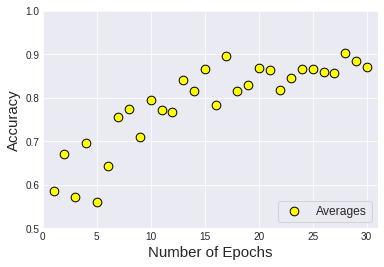

In [15]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2d_cr_val_acc.png', dpi=500)

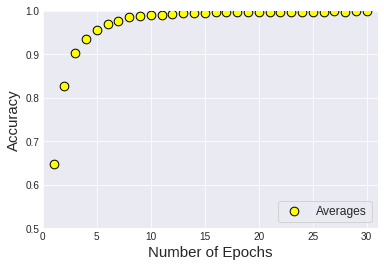

In [16]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2d_cr_acc.png', dpi=500)